In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


/Users/doriclink/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Generator(nn.Module):
    def __init__(self, latent_size,num_features, device):
        super(Generator, self,).__init__()
        self.num_features = num_features
        self.latent_size = latent_size
        self.device = device

        self.net = nn.Sequential(
            nn.ConvTranspose2d(self.latent_size, self.num_features*4, 7,1,0,bias=False),
            nn.BatchNorm2d(self.num_features*4),
            nn.ReLU(),
            nn.ConvTranspose2d(self.num_features*4, self.num_features*2, 4,2,1,bias=False),
            nn.BatchNorm2d(self.num_features*2),
            nn.ReLU(),
            nn.ConvTranspose2d(self.num_features*2, self.num_features, 4,2,1,bias=False),
            nn.BatchNorm2d(self.num_features),
            nn.ReLU(),
            nn.ConvTranspose2d(self.num_features, 1, 3,1,1,bias=False),
            nn.Tanh(),
        )
    def forward(self):
        X = torch.randn(128,100).unsqueeze(-1).unsqueeze(-1)
        X = X.to(self.device)
        return self.net(X)

class Discriminator(nn.Module):
    def __init__(self, num_features, device):
        super(Discriminator, self).__init__()
        self.device=device
        self.num_features = num_features

        self.net = nn.Sequential(
            nn.Conv2d(1, self.num_features, 4,2,1,bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.num_features, self.num_features*2, 4,2,1,bias=False),
            nn.BatchNorm2d(self.num_features*2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.num_features*2, self.num_features*4,4,2,1,bias=False),
            nn.BatchNorm2d(self.num_features*4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.num_features*4, 1, 4,2,1,bias=False),
            nn.Sigmoid()
            )

    def forward(self, X):
        return self.net(X).view(-1, 1).squeeze(1)

        


In [3]:
import torchvision
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5,0.5)
])

dataset = torchvision.datasets.MNIST("./data", train=True, transform=transforms)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
device = torch.device("mps")
gen = Generator(100, 32, device)
gen = gen.to(device)
disc = Discriminator(32, device)
disc=disc.to(device)

loss_fn = nn.BCELoss()

optim_gen = torch.optim.Adam(gen.parameters(), lr=2e-4)
optim_disc  = torch.optim.Adam(disc.parameters(), lr=2e-4)

disc_losses =  []
gen_losses = []
for ep in range(10):
    print(f"Starting epoch {ep}")
    for src, _ in tqdm(loader):
        optim_disc.zero_grad()
        optim_gen.zero_grad()
        src = src.to(device)

        real = src
        fake = gen()
        # print(fake.shape)


        disc_fake = disc(fake)
        # print(disc_fake.shape)
        disc_real = disc(real)

        disc_fake_loss = loss_fn(disc_fake, torch.zeros_like(disc_fake))
        disc_real_loss = loss_fn(disc_real, torch.ones_like(disc_real))

        disc_loss = (disc_real_loss + disc_fake_loss) / 2
        disc_losses.append(disc_loss.item())
        disc_loss.backward(retain_graph=True)
        optim_disc.step()

        out = disc(fake)
        gen_loss = loss_fn(out, torch.ones_like(out))
        gen_losses.append(gen_loss.item())
        gen_loss.backward()
        optim_gen.step()

Starting epoch 0


100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Starting epoch 1


100%|██████████| 469/469 [00:22<00:00, 20.86it/s]


Starting epoch 2


100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Starting epoch 3


100%|██████████| 469/469 [00:22<00:00, 20.94it/s]


Starting epoch 4


100%|██████████| 469/469 [00:22<00:00, 20.84it/s]


Starting epoch 5


100%|██████████| 469/469 [00:22<00:00, 20.62it/s]


Starting epoch 6


100%|██████████| 469/469 [00:22<00:00, 20.62it/s]


Starting epoch 7


100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


Starting epoch 8


100%|██████████| 469/469 [00:22<00:00, 20.87it/s]


Starting epoch 9


100%|██████████| 469/469 [00:22<00:00, 20.69it/s]


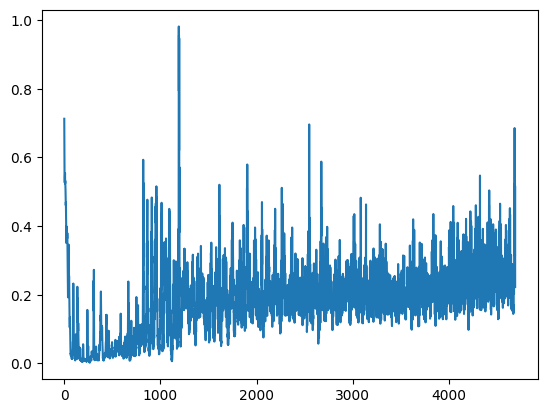

In [5]:
# plt.plot(gen_losses)
plt.plot(disc_losses)

In [6]:
from torchvision.utils import make_grid
def show_samples(samples, fname=None, nrow=10, title='Samples'):
    samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
    grid_img = make_grid(samples, nrow=nrow)
    plt.figure()
    plt.title(title)


    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')

    if fname is not None:
        print("Yow")
    else:
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 1, 28, 28])
tensor(0.9999) tensor(-1.)


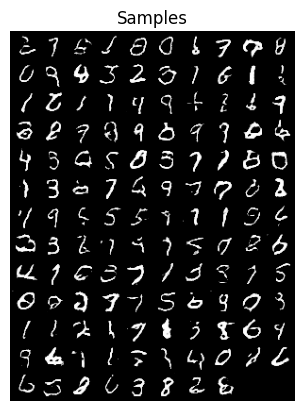

In [7]:
with torch.no_grad():
    gen.eval()
    preds = gen().cpu()
    print(preds.shape)
    print(torch.max(preds), torch.min(preds))

show_samples(preds.permute(0,2,3,1))